In [1]:
import numpy, pandas
import bluepy
import conntility
import os

from scipy.spatial import distance
from matplotlib import pyplot as plt

# HUNT ET AL. REFERS TO THE FOLLOWING PAPER:
# https://academic.oup.com/cercor/article/33/6/2857/6633911

# Hunt at al. distance bins
dbins = numpy.array([1E-4, 15, 30, 45, 60, 75, 90, 105])
# Number of samples taken per bin in Hunt et al.
smpl_counts = numpy.array([2, 54, 37, 36, 16, 11, 2])

# Describes which neurons to consider and which coordinates to use to sample them
load_cfg = {
    "loading":{    
        "properties": ["x", "y", "z", "mtype", "layer", "synapse_class"]
    },
    "filtering":[
        {
            "column": "synapse_class",
            "values": ["EXC"]
        },
        {
            "column": "layer",
            "values": ["L2", "L3"]
        }
    ]
}

# Rat
# fn_circ = "/gpfs/bbp.cscs.ch/project/proj83/circuits/Bio_M/20200805/CircuitConfig_TC_WM"
# fn_con_mat = "./rat_L23_sampled_cmat.h5"
# columns_slice=["ss_flat_x", "ss_flat_y"]
# column_y = "depth"
# population = "default"
# Rat is in atlas coordinates. Need to also load flat map coordinates
# load_cfg["loading"]["properties"] = load_cfg["loading"]["properties"] + ["ss_flat_x", "ss_flat_y", "depth"]

# Human
fn_circ = "/gpfs/bbp.cscs.ch/home/rai/proj140_home/circuit_building/phase-2/20230220/CircuitConfig"
fn_con_mat = "./human_l23_cmat.h5"
columns_slice=["x", "z"]  # The angle of the slice will be defined in this plane
column_y = "y" # This will be considered the vertical "depth" axis.
population = "hncx_neurons__hncx_neurons_chemical_synapse" # Name of the connectivity population to load

if os.path.exists(fn_con_mat):
    cmat = conntility.ConnectivityMatrix.from_h5(fn_con_mat)
else:
    circ = bluepy.Circuit(fn_circ)
    cmat = conntility.ConnectivityMatrix.from_bluepy(circ, load_config=load_cfg, population=population)
    cmat.to_h5(fn_con_mat)

We loaded the population of EXC neurons in layers L2 and L3, as well as the connectivity between them.
This is how the information is accessed

   gid layer     mtype synapse_class            x            y            z
0    1    L2  L23_PTPC           EXC   789.262777  2246.375160  1536.903634
1    2    L2  L23_PTPC           EXC  1074.354923  2246.291010   863.236751
2    3    L2  L23_PTPC           EXC   873.172620  2118.434582  2171.194641
3    4    L2  L23_PTPC           EXC   777.602595  2115.721849  2174.533391
4    5    L2  L23_PTPC           EXC   577.044815  2269.915047   303.298218


<55504x55504 sparse matrix of type '<class 'numpy.bool_'>'
	with 5173226 stored elements in COOrdinate format>

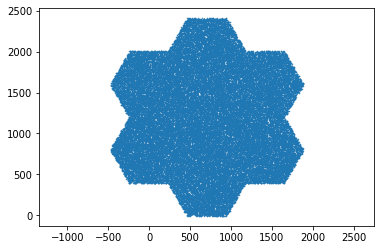

In [2]:
# Neuron information
print(cmat.vertices.head())
plt.plot(cmat.vertices["x"], cmat.vertices["z"], '.', ms=1)
_ = plt.axis("equal")

# Matrix of connections between neurons in this population
cmat.matrix

We first generate a slice of the population.

(-585.9811095275443,
 1996.3536568302245,
 -128.64953272592697,
 2528.7300134727193)

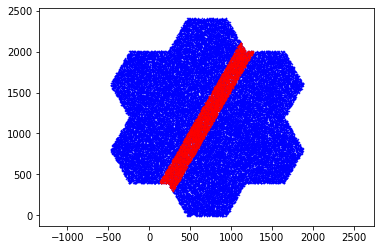

In [3]:
c_slice = cmat.slice(numpy.pi / 3., # Angle at which the slice is taken. Here, intentially very "diagonal"
                     0, # Offset of the slice from the center of the population
                     200.0, # Thickness in um
                     columns_slice=columns_slice, 
                     column_y=column_y)

plt.plot(cmat.vertices["x"], cmat.vertices["z"], '.b', ms=1)  # Full population
plt.plot(c_slice.vertices["x"], c_slice.vertices["z"], '.r', ms=1)  # Slice population in red
plt.axis("equal")

The slice also defines its own coordinate system. "slice_x" is horizontal within the slice, "slice_y" is vertical in the slice and aligned with cortical depth. "slice_depth" is aligned with the thickness of the slice.

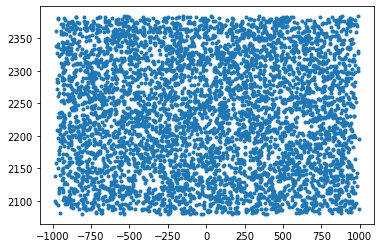

In [4]:
plt.plot(c_slice.vertices["slice_x"], c_slice.vertices["slice_y"], '.')

In the slice, we can now do patch experiments. The characteristics of the patch sample are defined by two parameters:
"mv_cv" is the covariance matrix of a multivariate gaussian that defines the extent of the area within which the experimenter is assumed to sample. 
In Hunt et al. the experimenter sampled more in the vertical dimension than the horizontal one. So we give that dimension a larger variance of 2000.

The other parameter is the number of neurons to patch.

Each call of the function will generate a random sample of patched cells with the defined statistics. 

In [5]:
from scipy import stats

n_patch = 4  # "Up to four" in Hunt et al.
mv_cv = numpy.array([[1000, 0],  # extent in slice x coordinates
                     [0, 2000]])  # and in slice y (vertical)

patch_sample = c_slice.patch_sample(n_patch, [0, 0], mv_cv, columns_xy=["slice_x", "slice_y"])

print(patch_sample.vertices)  # Neurons that were samples
print(patch_sample.array)  # connectivity array

   index layer     mtype synapse_class           x            y            z  \
0   9826    L2  L23_PTPC           EXC  606.204758  2261.414852  1135.075664   
1  37117    L2  L23_PTPC           EXC  682.933356  2286.243031  1077.193033   
2  46090    L2  L23_PTPC           EXC  679.632383  2267.572574  1093.458584   
3  42549    L2  L23_PTPC           EXC  721.383480  2253.075134  1055.052274   

      slice_x      slice_y  slice_depth  
0 -103.195805  2261.414852    48.829106  
1 -114.959335  2286.243031   -46.561125  
2 -102.523441  2267.572574   -35.569623  
3 -114.908733  2253.075134   -90.930288  
[[False False False False]
 [False False False False]
 [False False False False]
 [False False False False]]


We use this to run many patch experiments and gather statistics

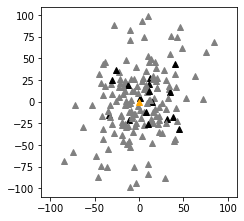

In [6]:
fig = plt.figure(figsize=(3.5, 3.5))
ax = fig.gca()
plot = True
yaxis_orientation_depth = -1 # Which direction of the y-axis is "depth"? Use 1 for rat, 
                             # but -1 for human, because in that model the y-axis is counting "upwards" from L6

stats_D = []
stats_M = []
stats_A = []

# Values below correspond to Hunt et al.
# Feel free to experiment with this
n_samples = 14
n_patched = 4

for _ in range(n_samples):
    smpl = c_slice.patch_sample(n_patched, [0., 0.], mv_cv, columns_xy=["slice_x", "slice_y"])
    smpl_coords = smpl.vertices[["slice_x", "slice_y"]]
    if yaxis_orientation_depth == 1:
        A = smpl_coords.values.reshape((1, n_patched, 2)) - smpl_coords.values.reshape((n_patched, 1, 2))
    else:
        A = smpl_coords.values.reshape((n_patched, 1, 2)) - smpl_coords.values.reshape((1, n_patched, 2))
    M = smpl.array
    for pt, c in zip(A.reshape((-1, 2)), M.reshape((-1,))):
        if numpy.abs(pt).sum() > 0 and plot:
            if c:
                ax.plot(*pt, '^', color="black")
            else:
                ax.plot(*pt, '^', color='grey')
    
    stats_D.append(numpy.sqrt((A ** 2).sum(axis=2)).flatten())  # Distances of sampled pairs
    stats_A.append(numpy.sign(A[:, :, 1]).flatten())  # For each pair: Was the presyn. neuron above?
    stats_M.append(M.flatten())  # Presence of connection for each pair

ax.plot(0, 0, '^', color="orange")
ax.set_xlim([-110, 110])
ax.set_ylim([-110, 110])

stats_D = numpy.hstack(stats_D)
stats_A = numpy.hstack(stats_A)
stats_M = numpy.hstack(stats_M)

Plot aggregate statistics

Text(0, 0.5, 'Connection probability')

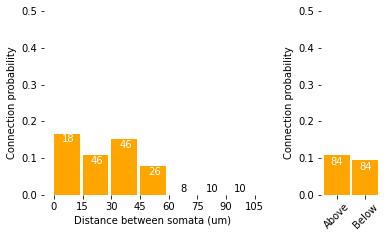

In [7]:
orientation_bins = [1, -1]
stats_bins = numpy.digitize(stats_D, bins=dbins)
mnM_d = [numpy.mean(stats_M[stats_bins == i]) for i in range(1, len(dbins))]
counts_d = numpy.histogram(stats_D, bins=dbins)[0]
mnM_a = [numpy.mean(stats_M[stats_A == i]) for i in orientation_bins]
counts_a = [numpy.sum(stats_A == i) for i in orientation_bins]

fig = plt.figure(figsize=(5.5, 3.))
ax = fig.add_axes([0.1, 0.1, 0.55, 0.85])
col = "orange"

ax.bar(dbins[:-1], mnM_d, color=col, width=0.9*numpy.mean(numpy.diff(dbins)), align="edge")
for i, y in enumerate(mnM_d):
    x = 0.5 * (dbins[i] + dbins[i + 1])
    v = counts_d[i]
    if y > 0:
        ax.text(x, y-0.002, "{0}".format(v), color="white", horizontalalignment="center", verticalalignment="top")
    else:
        ax.text(x, y+0.001, "{0}".format(v), color="black", horizontalalignment="center", verticalalignment="bottom")
ax.set_xticks(dbins)
ax.set_frame_on(False)
ax.set_ylim([0, 0.5])
ax.set_ylabel("Connection probability")
ax.set_xlabel("Distance between somata (um)")

ax = fig.add_axes([0.8, 0.1, 0.15, 0.85])

ax.bar([0, 1], mnM_a, color=col, width=0.9)
for i, y in enumerate(mnM_a):
    x = i
    v = counts_a[i]
    if y > 0:
        ax.text(x, y-0.005, "{0}".format(v), color="white", horizontalalignment="center", verticalalignment="top")
    else:
        ax.text(x, y+0.001, "{0}".format(v), color="black", horizontalalignment="center", verticalalignment="bottom")
    ax.set_xticks([0, 1]); ax.set_xticklabels(["Above", "Below"], rotation=45.)
ax.set_frame_on(False)
ax.set_ylim([0, 0.5])
ax.set_ylabel("Connection probability")

We can also calculate the "actual" values, i.e. calculated for all pairs. Not just randomly sampled.

Text(0, 0.5, 'Connection probability')

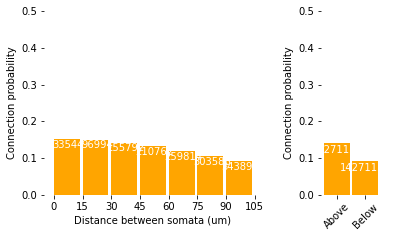

In [8]:
D = distance.squareform(distance.pdist(c_slice.vertices[["slice_x", "slice_y"]]))
O = c_slice.vertices["slice_y"].values.reshape((-1, 1)) - c_slice.vertices["slice_y"].values.reshape((1, -1))

Dbins = numpy.digitize(D, bins=dbins)
M = c_slice.dense_matrix

p_in_bins = numpy.array([
    M[Dbins == i].mean() for i in range(1, len(dbins))
])
p_for_orientation = numpy.array([
    M[(O > 0) & (D < dbins[-1])].mean(), M[(O < 0) & (D < dbins[-1])].mean()  # Sample all pairs, but within the same distance
])
count_in_bins = numpy.histogram(D, bins=dbins)[0]
count_for_orientation = numpy.array([(O > 0).sum(), (O < 0).sum()])


fig = plt.figure(figsize=(5.5, 3.))
ax = fig.add_axes([0.1, 0.1, 0.55, 0.85])
col = "orange"

ax.bar(dbins[:-1], p_in_bins, color=col, width=0.9*numpy.mean(numpy.diff(dbins)), align="edge")
for i, y in enumerate(p_in_bins):
    x = 0.5 * (dbins[i] + dbins[i + 1])
    v = count_in_bins[i]
    if y > 0:
        ax.text(x, y-0.002, "{0}".format(v), color="white", horizontalalignment="center", verticalalignment="top")
    else:
        ax.text(x, y+0.001, "{0}".format(v), color="black", horizontalalignment="center", verticalalignment="bottom")
ax.set_xticks(dbins)
ax.set_frame_on(False)
ax.set_ylim([0, 0.5])
ax.set_ylabel("Connection probability")
ax.set_xlabel("Distance between somata (um)")

ax = fig.add_axes([0.8, 0.1, 0.15, 0.85])

ax.bar([0, 1], p_for_orientation, color=col, width=0.9)
for i, y in enumerate(p_for_orientation):
    x = i
    v = count_for_orientation[i]
    if y > 0:
        ax.text(x, y-0.005, "{0}".format(v), color="white", horizontalalignment="center", verticalalignment="top")
    else:
        ax.text(x, y+0.001, "{0}".format(v), color="black", horizontalalignment="center", verticalalignment="bottom")
    ax.set_xticks([0, 1]); ax.set_xticklabels(["Above", "Below"], rotation=45.)
ax.set_frame_on(False)
ax.set_ylim([0, 0.5])
ax.set_ylabel("Connection probability")